# CS4248 Project - Labelled Unreliable News (LUN)

**Some bug with the training: loss nan and accuracy 0**

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
full_train_df = pd.read_csv('raw_data/fulltrain.csv', header=None)
full_train_df.columns = ['label', 'text']
full_train_df.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [6]:
train_df = full_train_df.drop_duplicates(subset=['text'])
print(f"No. training samples (all classes): {len(train_df)}")

sample_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.25))
print(f"No. training samples (sampled classes): {len(sample_df)}")


No. training samples (all classes): 48652
No. training samples (sampled classes): 12164


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [9]:
train_df, test_df = train_test_split(sample_df, test_size=0.2, stratify=sample_df["label"], random_state=42)
train_df.size, test_df.size

(19462, 4866)

In [10]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset

Dataset({
    features: ['label', 'text', '__index_level_0__', '__index_level_1__'],
    num_rows: 9731
})

In [11]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_train

Map:   0%|          | 0/9731 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', '__index_level_0__', '__index_level_1__', 'input_ids', 'attention_mask'],
    num_rows: 9731
})

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [14]:
import evaluate

accuracy = evaluate.load("accuracy")

In [15]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [16]:
id2label = {1: "satire", 2: "hoax", 3: "propaganda", 4:"reliable"}
label2id = {"satire": 1, "hoax": 2, "propaganda": 3, "reliable": 4}

In [17]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 30
batches_per_epoch = len(tokenized_train) // batch_size
batches_per_epoch = len(tokenized_test) // batch_size

total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [18]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [19]:
tf_train_set = model.prepare_tf_dataset(
    # tokenized_text["train"],
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [41]:
import tensorflow as tf

# model.compile(optimizer=optimizer)
model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [42]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [43]:
callbacks = [metric_callback]

In [44]:
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=callbacks)

Epoch 1/3
608/608 [==============================] - 699s 1s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/3
608/608 [==============================] - 628s 1s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/3
608/608 [==============================] - 619s 1s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


## Validation

In [45]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
inputs = tokenizer(text, return_tensors="tf")

In [47]:
from transformers import TFAutoModelForSequenceClassification

# model = TFAutoModelForSequenceClassification.from_pretrained("stevhliu/my_awesome_model")
logits = model(**inputs).logits

In [48]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id + 1]

'satire'

In [49]:
test_df = pd.read_csv('raw_data/balancedtest.csv', header=None, names=['label', 'text'])
print(f"No. test samples (all classes): {len(test_df)}")
test_df.sample(5)

No. test samples (all classes): 3000


,label,text
2318,4,The plaintiff in the lawsuit that legalized ab...
2782,4,"Bob Franks, 58, who served four terms in the U..."
482,1,Youve probably seen a lot of eerily similar ce...
1278,2,Establishment Political Hit On Trump - Duke La...
2177,3,As many areas of the country perspire their w...


In [50]:
X_val = test_df['text'].values
y_val = test_df['label'].values

In [51]:
from transformers import AutoTokenizer

def pred(text):
    inputs = tokenizer(text, return_tensors="tf")
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    pred_class = predicted_class_id + 1
    return pred_class

y_pred_val = [pred(text) for text in X_val]
    

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


In [52]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

print(f"Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"F1 score: {f1_score(y_val, y_pred_val, average='macro')}")

Accuracy: 0.25
F1 score: 0.1


In [53]:
print(classification_report(y_val, y_pred_val, target_names=['satire', 'hoax', 'propaganda', 'reliable']))

              precision    recall  f1-score   support

      satire       0.25      1.00      0.40       750
        hoax       0.00      0.00      0.00       750
  propaganda       0.00      0.00      0.00       750
    reliable       0.00      0.00      0.00       750

    accuracy                           0.25      3000
   macro avg       0.06      0.25      0.10      3000
weighted avg       0.06      0.25      0.10      3000



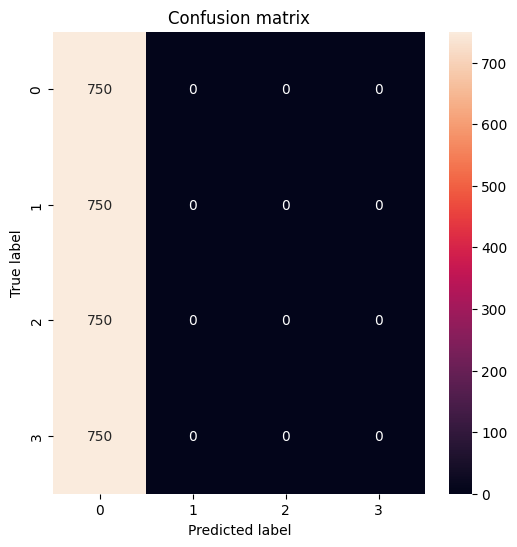

In [54]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()	